# **Worksheet 06: Prediction and Model Selection**

## **Lecture and Tutorial Learning Goals:**

By the end of this section, students will be able to:

- Explain the difference between confidence intervals for prediction and prediction confidence intervals and what elements need to be estimated to construct these intervals.

- Write a computer script to calculate these intervals. Interpret and communicate the results from that computer script.

- Give an example of a question that can be answered by predictive modelling.

- Explain the algorithms for the following variable selection methods: • Forward selection • Backward selection

- Explain when linear regression is an appropriate model to predict new outcomes based on new values of the input variables.

- List model metrics suitable for evaluating a statistical model developed for predictive modelling (e.g., RMSE) and how they are calculated.

- Discuss how different estimation methods can result in different predictions.

In [1]:
# Loading Libraries

library(broom)
library(latex2exp)
library(tidymodels)
library(repr)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(tidyverse)
library(modelr)
source("tests_worksheet_06.R")

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ dials        1.2.1     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.2     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘mltools’


The following objects are masked from ‘package:yardstick’:

    mcc, rmse


The following object is masked from ‘package:tidyr’:


# **Part I: Uncertainty of prediction**

## **1.1. Prediction Intervals *vs* Confidence Intervals for prediction**

Last week, we saw that the estimated LR can be used to predict the values of the response variable. 

We have also learned different metrics to evaluate the estimated model, many of which compare the observed response $y$ with its predicted value using the estimated LR $\hat{y}$. For example:


- Mean Squared Error (MSE): $$\text{MSE} = \frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2$$

- $R^2 = cor(y, \hat{y})^2$ (for a model with an intercept estimated by LS)

Today, we will measure the uncertainty of $\hat{Y}$. Note that since the predictions are functions of the estimated LR, they also depend on the sample used. A different sample would have resulted in a different estimated LR and, thus, different predictions. Therefore, predictions are random variables. The sample-to-sample variation in the estimated coefficients translates into variation in the predictions.

<font color="darkred">As we did when estimating the regression parameters, we can also obtain *confidence intervals* for the predictions by considering the sample-to-sample variation.</font>
    
Depending on the quantity we want to predict, we can construct two types of intervals: **confidence intervals for prediction (CIP)** and **prediction intervals (PI)**. Let's introduce these concepts by fitting an SLR (note that these intervals can be constructed for any LR).  

## **1.2. <u>Dataset: </u>[<u>2015 Property Tax Assessment from Strathcona County</u>](https://data.strathcona.ca/Housing-Buildings/2015-Property-Tax-Assessment/uexh-8sx8)**

In this first part of the worksheet, we'll work with a new dataset containing data on property tax-assessed values in Strathcona County. The dataset provides a valuation date of July 1, 2014, and a property condition date of December 31, 2014. 

![](https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/popul_AB.png?raw=true)

Let's start by loading the data, but to work with smaller numbers, we will divide the assessed value by 1000. 

In [2]:
# Loads the data and re-scale the assessed values.

properties_data <- 
    read.csv("data/Assessment_2015.csv") %>%
    filter(ASSESSCLAS=="Residential")  %>% 
    mutate(assess_val = ASSESSMENT / 1000)

Unfortunately, unless we work with a simulated dataset, the true population parameters are *unknown*. However, to illustrate concepts while working with a real dataset, and avoid simulating data,  we'll use all the residencies in the dataset to obtain an LR and **pretend** that this is the population line.

> <font color='darkred'>**THIS IS NOT DONE IN REAL DATA ANALYSIS!** We are doing this here for teaching purposes only. In practice, your entire dataset is your sample. </font>

So, let's select a sample from our `property_data`.

In [3]:
set.seed(561) # DO NOT CHANGE THIS.

# A sample out of our bigger sample properties_data, 
# which we are PRETENDING to be population (but IT ISN'T)

properties_sample <- 
    properties_data %>%
    slice_sample(n = 100, replace = FALSE)

Next, let's fit:

- **Sample linear model** using the sample we just took in `properties_sample`;

- **Population linear model** using the entire dataset in `properties_data`; (again, this is not the actual population model - we are just pretending it to be to study the sample-to-sample variability.)

In [4]:
lm_pop <- lm(assess_val ~ BLDG_METRE, properties_data)
lm_sample <- lm(assess_val ~ BLDG_METRE, properties_sample)

tidy(lm_sample) %>% 
    mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),34.456,38.055,0.905,0.367
BLDG_METRE,3.071,0.228,13.446,0.000


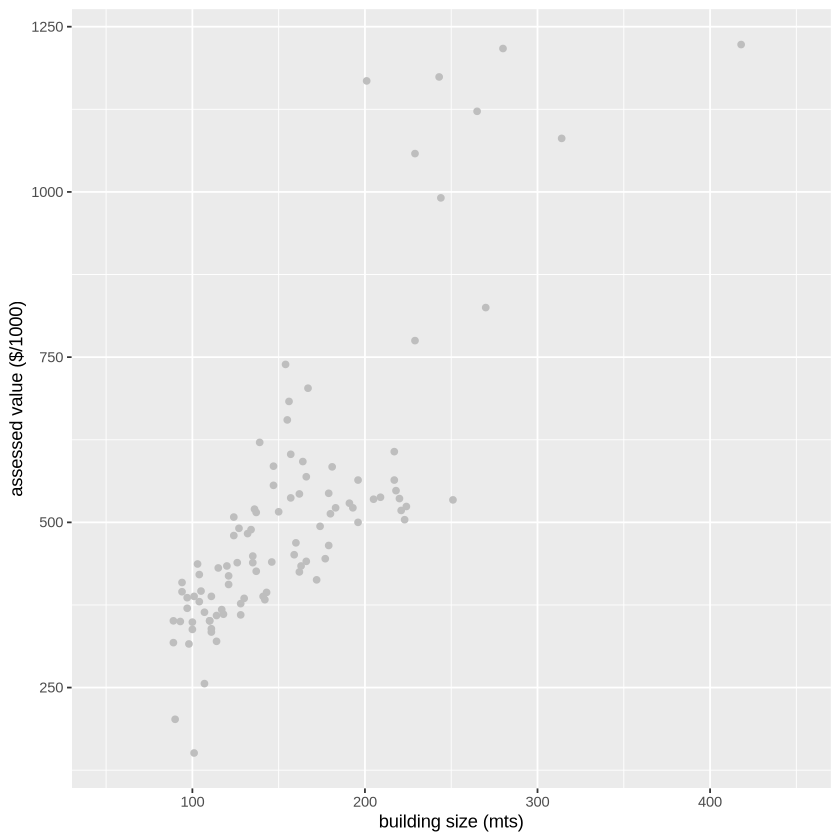

In [5]:
cols <- c("Population"="#f04546","LS Estimate"="#3591d1")

plot_sample <- 
    properties_sample %>%
    ggplot(aes(BLDG_METRE, assess_val)) + 
    xlab("building size (mts)") + 
    ylab("assessed value ($/1000)") +
    xlim(50, 450) +
    geom_point(aes(BLDG_METRE, assess_val), color="grey")
plot_sample 

### **1.2.1 Prediction of the assessed value of a house in Strathcona**

The assessed value of a random house in Strathcona can be modelled as the average assessed value of a house with similar characteristics plus some random error.

Mathematically,

$$Y_i = E[Y_i|X_{i}] + \varepsilon_i$$

The $\varepsilon_i$ term is necessary because a random residence won't have a value exactly equal to the average population value of residencies of the same size; some have higher values, and others have lower values. 

In addition, if we assume that the conditional expectation is linear, then:

$$ E[Y_i|X_{i}] = \beta_0 + \beta_1 X_{i}$$

which is the population regression line. 

Since we are **pretending** that we know this population line, we can plot it. But once again, recall that in practice this line is *unknown*.

In [6]:
# Run this before continuing.

# Don't worry about reading and understanding this code. 
# You can just run and skip it.

plot_expect <- 
    plot_sample +
    geom_smooth(data = properties_data, 
                aes(BLDG_METRE, assess_val, color = "Population"),
                method = lm, 
                linetype = 2, 
                se = FALSE, 
                fullrange = TRUE) +
    geom_point(aes(x = 251, y = predict(lm_pop, tibble(BLDG_METRE = 251))), 
               color = "red", 
               size = 3) +  
    annotate('text',
             x = 300,
             y = 715,
             label = "paste('E[',Y[i],' | ', X[i],' ]')", 
             color = "red", 
             size = 7,
             parse = TRUE) +
    geom_point(aes(x = 251,y = 534), color = "black", size = 3) +
    annotate("text",
             x = 265, 
             y = 500, 
             label = 'paste(y[i])', 
             size = 7, 
             parse = TRUE) +
    geom_segment(x = 251, 
                 y = predict(lm_pop, tibble(BLDG_METRE = 251)),
                 xend = 251, 
                 yend = 534, 
                 linetype = "dashed") +
    annotate("text", 
             x = 240,
             y = 630,
             label = 'paste(epsilon[i])', , 
             size = 7,
             parse = TRUE) +
    scale_colour_manual(name = "SLR", values = cols) + 
    theme(text = element_text(size = 16))

Warning message in geom_point(aes(x = 251, y = predict(lm_pop, tibble(BLDG_METRE = 251))), :
“All aesthetics have length 1, but the data has 100 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = 251, y = 534), color = "black", size = 3):
“All aesthetics have length 1, but the data has 100 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 98 rows containing non-finite outside the scale range
(`stat_smooth()`).”


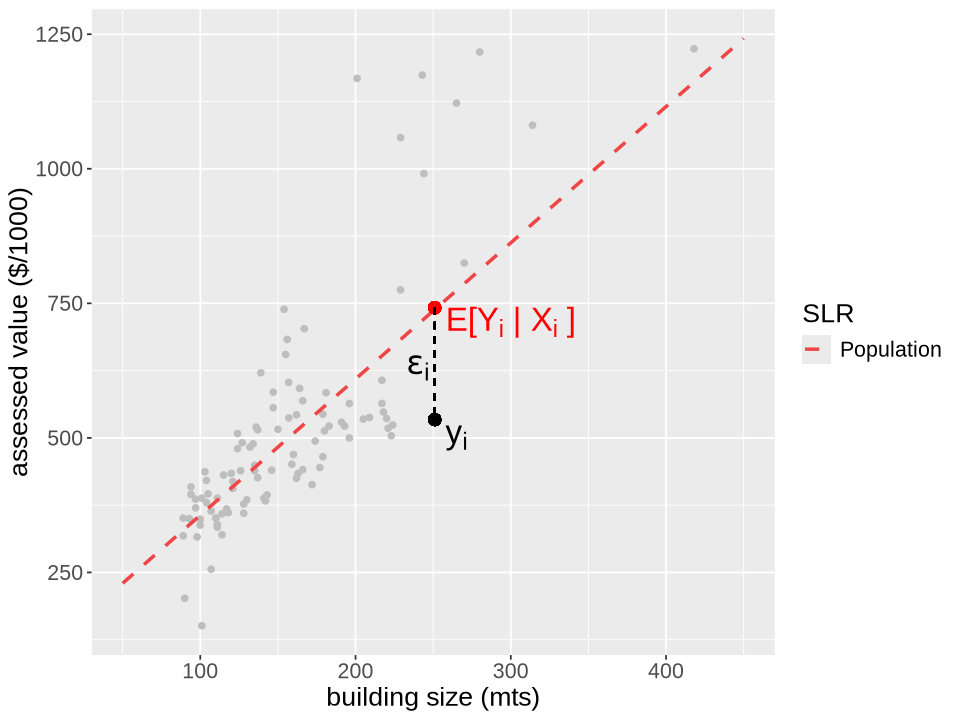

In [7]:
# Run this before continuing 

# Edit this to make the plot look good in your desktop
options(repr.plot.width=8, repr.plot.height=6)

plot_expect 

### **1.2.2 Estimated Linear Regression**

In practice, we use the random sample to estimate the regression line. In this case, we estimate the relation between a house's assessed value and size based on a random sample of houses from Strathcona. We use the **estimated** relation to predict the value of any house in the county.

 The prediction of the $i$-th observation is given by:

$$\hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_{i}$$

In [8]:
# Run this before continuing.

# Don't worry about reading and understanding this code. 
# You can just run and skip it.

plot_ls <- 
    plot_expect +    
    geom_smooth(data = properties_sample, 
                aes(BLDG_METRE, assess_val, color = "LS Estimate"),
                method = lm,
                se = FALSE,
                fullrange = TRUE) +
    geom_point(aes(x = 251, y = predict(lm_sample, tibble(BLDG_METRE = 251))),
               color = "blue",
               size = 3) +
    annotate('text',
             x = 240, 
             y = predict(lm_sample, tibble(BLDG_METRE = 251)) + 60, 
             label = 'paste(hat(y)[i])', 
             color = "blue", 
             size = 7,
             parse = TRUE)

Warning message in geom_point(aes(x = 251, y = predict(lm_pop, tibble(BLDG_METRE = 251))), :
“All aesthetics have length 1, but the data has 100 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = 251, y = 534), color = "black", size = 3):
“All aesthetics have length 1, but the data has 100 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_point(aes(x = 251, y = predict(lm_sample, tibble(BLDG_METRE = 251))), :
“All aesthetics have length 1, but the data has 100 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 98 rows containing non-finite outside the scale range
(`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'


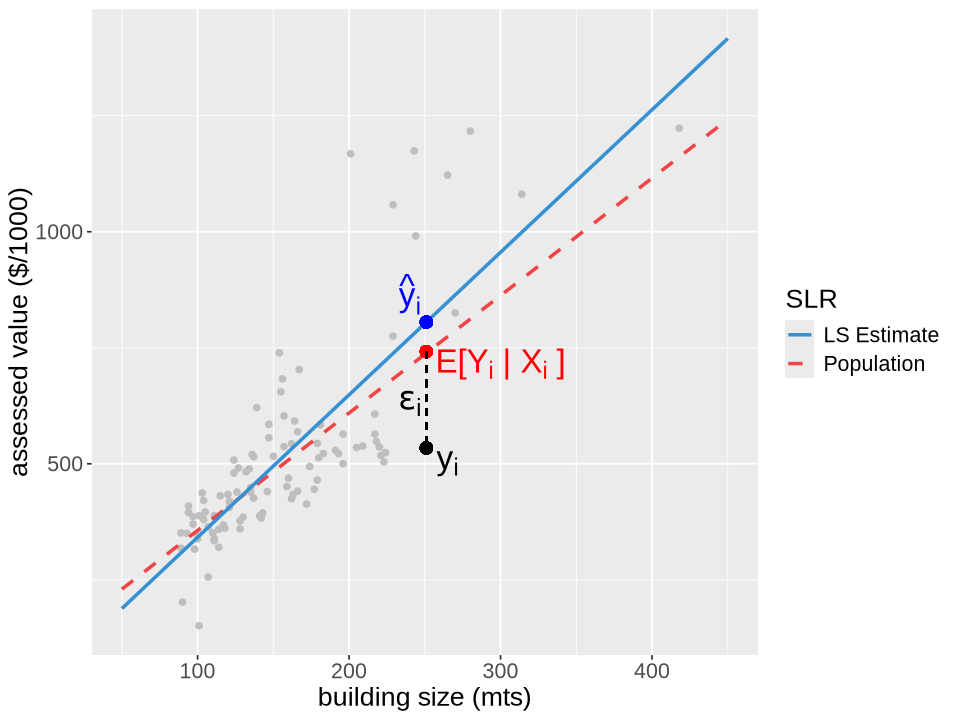

In [9]:
# Run this before continuing 
plot_ls

Finally, note that the $\varepsilon_i$ is the difference between $y_i$ and $E(Y_i|X_i)$, while the difference between $y_i$ and $\hat{y}_i$ is the "estimated" error, $e_i$. Also, $\varepsilon_i$ will always be unknown since, in practice, $E(Y_i|X_i)$ is unknown.

### **1.2.3 Intervals to describe uncertainty**

What do we want to predict with </u><font color=blue> $\hat{Y}_i$</font>? In general, we are interested in predicting either:

- the *average* assessed value of a house of *this size*: <font color=red> $E[Y_i|X_i]$ </font>

- the *actual* value of a house of *this size*: $Y_i$ (knowing its size $X_i$)

Note that we predict both with *uncertainty*. 

**Question:** Which one do you think is more difficult to predict? Why? Discuss with a colleague.

Let's start with the first case, i.e., when we want to predict $E[Y_i|X_i]$.

#### **<u>Confidence Intervals for Prediction (CIP)</u>**

In this case, we want to estimate $E[Y_i|X_i]$. The predicted value <font color=blue> $ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_{i}$ </font> approximates, with uncertainty, the <font color=red> population $ E[Y_i| X_{i}] = \beta_0 + \beta_1 X_{i}$ </font>. Remember, if we take a different sample, we get different estimates (i.e., different blue lines) and, consequently, different predictions. 

<font color='darkred'>The only source of variation here is the sample-to-sample variation.</font>

Then, a 95% confidence interval for prediction is a range that has a 95% probability of capturing the true average value of a house with size $X_i$. Again, remember that once we have estimated values and a numerical range based on the sample, we use the word "confidence" (instead of "probability") since nothing else is random.

**A quick look at data**

Using the sample `properties_sample`, let's compute 95% confidence intervals for prediction using the function `predict`. 

- Create a dataframe, called `properties_cip`, that contains the response, the input, the predictions using `lm_sample`, and the lower and upper bounds of the intervals for *each* observation

> each row corresponds to one (in-sample) prediction and its confidence interval

In [10]:
properties_cip <- 
    properties_sample  %>% 
    select(assess_val, BLDG_METRE) %>% 
    cbind(predict(lm_sample, interval="confidence", se.fit=TRUE)$fit)

In [11]:
head(properties_cip,3)

,assess_val,BLDG_METRE,fit,lwr,upr
,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,536,220,710.0708,671.9440,748.1977
2,370,97,332.3407,295.2144,369.4669
3,318,89,307.7729,267.9136,347.6321


<br>

**Interpretation** for row 1: with 95% confidence, the *expected* value of a house of size 220 mts is between $\$671,944$ and $\$748,198$ (rounded)

<br>

**Visualization**

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 98 rows containing non-finite outside the scale range
(`stat_smooth()`).”


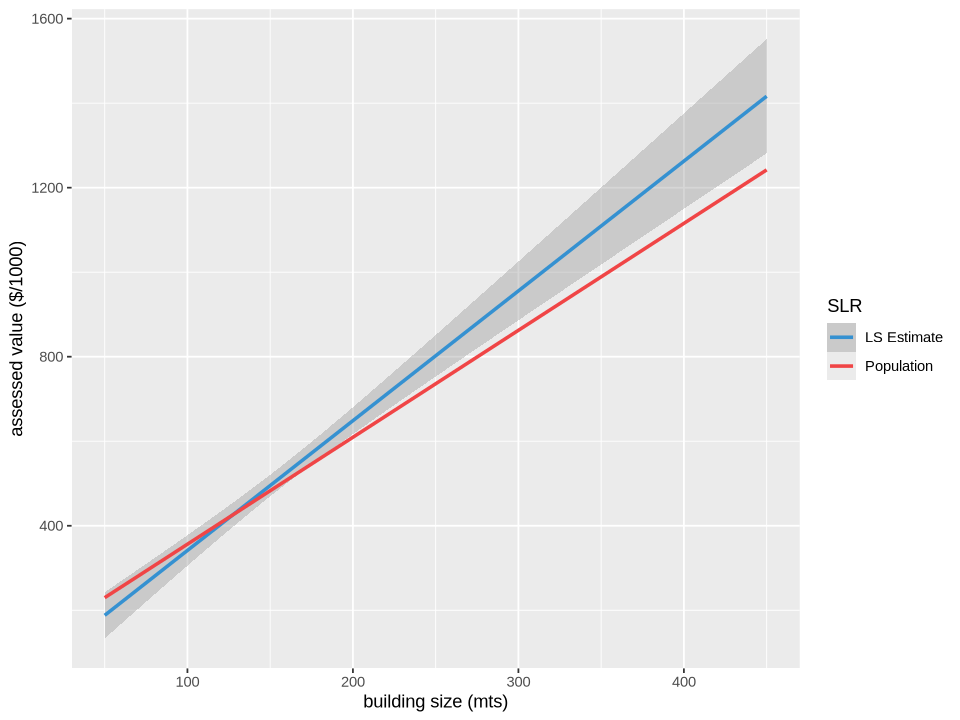

In [12]:
properties_sample %>%
    ggplot(aes(BLDG_METRE, assess_val)) + 
        xlab("building size (mts)") + 
        ylab("assessed value ($/1000)") +
        xlim(50,450) + 
        geom_smooth(aes(color="LS Estimate"), method = lm, se = TRUE, fullrange = TRUE) +
        geom_smooth(data = properties_data, 
                    aes(BLDG_METRE, assess_val, color="Population"),
                    method = lm,
                    se = FALSE,
                    fullrange = TRUE) +        
        scale_colour_manual(name="SLR",values=cols)

**Question 1.0** <br>
{points: 1}

Using the sample `properties_sample`, compute 90% confidence intervals for prediction. Create a data frame called `properties_cip_90` that contains the response, the input, the predictions using `lm_sample`, and the lower and upper bounds of the intervals for each observation. Columns in your data frame should be in this order.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [13]:
 # properties_cip_90 <- 
 #    ...  %>% 
 #    select(..., ...) %>% 
 #    cbind(...(..., 
 #              interval = "...", 
 #              level = ..., 
 #              se.fit=TRUE)$fit)

# your code here
fail() # No Answer - remove if you provide an answer

head(properties_cip_90)

ERROR: Error: Failure has been forced


In [14]:
test_1.0()

── Failure: Did not assign answer to an object called  properties_cip_90 ───────
exists(var_name) is not TRUE

`actual`:   FALSE
`expected`: TRUE 



ERROR: [1m[33mError[39m:[22m
[33m![39m Test failed


**Question 1.1** 
{points: 1}

Based on the output `properties_cip_90`, which of the following claims is correct?

**A.** with 90% confidence, the *expected* value of a house of size 97 mts is between \\$301274 and \\$363407 (rounded) 

**B.** with 90% confidence, the value of a house of size 97 mts is between \\$301274 and \\$363407 (rounded) 


**C.** with 90% confidence, the *expected* value of a house of size 97 mts is between \\$678167 and \\$741974 (rounded) 


**D.** with 90% confidence, the *expected* value of any house is between \\$678167 and \\$741974 (rounded) 


*Assign your answer to an object called `answer1.1`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"` surrounded by quotes. *

In [ ]:
# answer1.1 <- 

# your code here
fail() # No Answer - remove if you provide an answer

In [ ]:
test_1.1()

**Question 1.2** 
{points: 1}

True or false?

Based on the outputs `properties_cip_90` and `properties_cip`, CIP are centered at the fitted value  <font color=blue>$\hat{Y}_i$ </font>

*Assign your answer to an object called `answer1.2`. Your answer should be either `"true"` or `"false"`, surrounded by quotes.*

In [ ]:
# answer1.2 <- 

# your code here
fail() # No Answer - remove if you provide an answer

In [ ]:
test_1.2()

**Question 1.3** 
{points: 1}

True or false?

The 90% confidence intervals for prediction are wider than the 95% confidence intervals for prediction

*Assign your answer to an object called `answer1.3`. Your answer should be either `"true"` or `"false"`, surrounded by quotes.*

In [ ]:
# answer1.3 <- 

# your code here
fail() # No Answer - remove if you provide an answer

In [ ]:
test_1.3()

#### **<u> Prediction Intervals (PI)</u>**

The predicted value <font color=blue> $ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_{i}$ </font> also approximates, with uncertainty, an actual observation $ Y_i = \beta_0 + \beta_1 X_{i} + \varepsilon_i$. 
However, now the uncertainty comes from the estimation (sample-to-sample variability) and the error term that generates the data. In other words, we have two sources of uncertainty:

- **uncertainty 1**: because the estimated value <font color=blue> $\hat{\beta}_0 + \hat{\beta}_1 X_i$ </font> *approximates* the average (population) value <font color=red>$\beta_0 + \beta_1 X_i$</font>. 

- **uncertainty 2**: because the actual observation $Y_i$ differs from the population average value by an error $\varepsilon_i$

PIs are centred at the fitted value <font color=blue>$\hat{Y}_i$</font> as well, but they are wider than the CIP because of the extra uncertainty.

A 95% prediction interval is a range that, with 95% probability, contains the actual value of a house of this size. Again, for a particular interval based on an observed random sample, we replace "probability" with "confidence"

**A quick look at data**

In [ ]:
properties_pi <- 
    properties_sample  %>% 
    select(assess_val, BLDG_METRE) %>% 
    cbind(predict(lm_sample, interval="prediction"))

In [ ]:
head(properties_pi, 3)

Each row corresponds to one (in-sample) prediction and its confidence interval.

<br>

**Interpretation** for row 1: with 95% confidence, the value of a house of size 220 mts is between $\$454,519$ and $\$965,622$ (rounded).

<br>

**Question 1.4** 
{points: 1}

Let's use the results in `properties_cip` and `properties_pi` to corroborate that the prediction intervals are wider than the confidence intervals for prediction. You will:

1. calculate the length of the intervals for `properties_pi` (name the column `len_pi`) and `properties_cpi` (name the column `len_cip`). 
2. `left_join` the data from both tibbles by `assess_val` and `BLDG_METRE` (you'll see a warning of many-to-many relationships that you can ignore for our purposes here). 
3. count how many of the `len_cip` are higher than `len_ci` using `summarise`. 
4. pull the value out of the tibble with `pull()` and store it in a variable called `n_cpi_wider`. 

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
# your code here
fail() # No Answer - remove if you provide an answer

n_cpi_wider

In [ ]:
test_1.4()

## **1.3 Conclusions Part I: Prediction uncertainty**

- Confidence intervals for prediction account for the uncertainty given by the estimated LR to predict the conditional expectation of the response


- Prediction intervals account for the uncertainty given by the estimated LR to predict the conditional expectation of the response, *plus* the error that generates the data! 


- PIs are wider than CIPs; both are centered at the fitted value!

![](https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/pred_error.png?raw=true)

# **PART II: Model Selection**

In this part, we will focus on selecting a subset of variables to include in the model. Do we actually need all the available input variables? Some datasets contain *many* variables, but not all of them are relevant. To decide if a variable (or set of variables) is relevant, we need to choose an evaluation metric. The evaluation metric used depends on the goal of the analysis. So, what is your goal? Inference or prediction?
    


## **2.1 Variable selection for generative models**

In previous worksheets, we learned different selection and estimation methods when the goal is to *estimate and make inferences about* the model that generated the data. We referred to these models as *generative models*.

For a LR with an intercept and estimated by LS:

- The $\mathbf{R^2}$, coefficient of determination, can be used to measure the part of the variation in the response explained by the estimated model


- The **Adjusted $\mathbf{R^2}$** can be used to compare the fit of estimated models of different sizes


- The **MSE** (based on in-sample data) can be used to compare the observed values with those predicted by the estimated model  


- These $\mathbf{F}$ tests can be used to select variables by comparing nested models

## **2.2 Variable selection for predictive models**

How do we evaluate the predictive performance of a model? For regression models, two common choices are:

- **Mean Squared Error (MSE)**: $$\text{MSE}_{\text{test}} = \frac{1}{n_{\text{new}}}\sum_{i=1}^{n_{\text{new}}}(y^{\text{new}}_i - \widehat{y}^{\text{new}}_i)^2$$
<font color='darkred'>where $y^{\text{new}}_i$ are **new responses from the test set**</font>, $\widehat{y}^{\text{new}}_i$ are the predicted values using the LR estimated with the training data but with the input data from the test set, and $n_{\text{new}}$ is the number of data points in the test set. You *do not want* to use the data in the training set to evaluate your model. 

- **Root Mean Squared Error (RMSE)**: this is the square root of MSE.
$$\text{RMSE}_{\text{test}} = \sqrt{\text{MSE}_{\text{test}}} = \sqrt{\frac{1}{n_{\text{new}}}\sum_{i=1}^{n_{\text{new}}}(y^{\text{new}}_i - \widehat{y}_i)^2}$$
Once again, remember that $y_i$ are observations in the test set and weren't used to train the model. 

<br>

<br>

Another possibility, not really common for prediction is the $R^2$.
- **$R^2$**: remember that $R^2$ can be computed for new responses in a test set.
$$R^2 = cor(\boldsymbol{y}^{\text{new}}, \widehat{\boldsymbol{y}}^{\text{new}})$$
Some functions compute the $R^2$ from a validation set or using cross-validation (perhaps seen in other courses). However, note that it is ***no longer the coefficient of determination***. It measures the correlation between the true and the predicted responses *in a test set*.   

<br> 
<hr>
<br>

There are other common metrics that have been proposed to approximate the *test MSE* but are computed with the training set only. You can use these measures to select variables of predictive models, even without using a test set.

- $C_p$:

- $AIC$:

- $BIC$: 

## **2.3 Dataset: the [Ames `Housing` dataset](https://www.kaggle.com/c/home-data-for-ml-course/)**

In this section, we will work with a real estate dataset, the [Ames `Housing` dataset](https://www.kaggle.com/c/home-data-for-ml-course/), compiled by Dean De Cock. It has 79 input variables on different characteristics of residential houses in Ames, Iowa, USA, that can be used to predict the property's final price, `SalePrice.` We will use the following continuous input variables:

- `LotFrontage`: Linear $\text{ft}$ of street connected to the house.
- `LotArea`: Lot size in $\text{ft}^2$.
- `MasVnrArea`: Masonry veneer area in $\text{ft}^2$.
- `TotalBsmtSF`: Total $\text{ft}^2$ of basement area.
- `GrLivArea`: Above grade (ground) living area in $\text{ft}^2$.
- `BsmtFullBath`: Number of full bathrooms in the basement.
- `BsmtHalfBath`: Number of half bathrooms in the basement.
- `FullBath`: Number of full bathrooms above grade.
- `HalfBath`: Number of half bathrooms above grade.
- `BedroomAbvGr`: Number of bedrooms above grade (it does not include basement bedrooms).
- `KitchenAbvGr`: Number of kitchens above grade.
- `Fireplaces`: Number of fireplaces.
- `GarageArea`: Garage's area in $\text{ft}^2$.
- `WoodDeckSF`: Wood deck area in $\text{ft}^2$.
- `OpenPorchSF`: Open porch area in $\text{ft}^2$.
- `EnclosedPorch`: Enclosed porch area in $\text{ft}^2$.
- `ScreenPorch`: Screen porch area in $\text{ft}^2$.
- `PoolArea`: Pool area in $\text{ft}^2$.

The following variables will be used to construct a variable `ageSold`
- `YearBuilt`: Original construction date.
- `YrSold`: Year sold.

Run this code to prepare a working dataset

In [15]:
# Run this cell
housing <- 
    read_csv("data/Housing.csv") %>%
    mutate(ageSold = YrSold - YearBuilt) %>%
    select(LotFrontage, LotArea, MasVnrArea, TotalBsmtSF,
           GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, 
           HalfBath, BedroomAbvGr, KitchenAbvGr, Fireplaces,
           GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 
           ScreenPorch, PoolArea, ageSold, SalePrice) %>%
    drop_na() %>%
    filter(LotArea < 20000)

str(housing)

Rows: 1460 Columns: 81
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (43): MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConf...
dbl (38): Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, Ye...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tibble [1,162 × 20] (S3: tbl_df/tbl/data.frame)
 $ LotFrontage  : num [1:1162] 65 80 68 60 84 85 75 51 50 70 ...
 $ LotArea      : num [1:1162] 8450 9600 11250 9550 14260 ...
 $ MasVnrArea   : num [1:1162] 196 0 162 0 350 0 186 0 0 0 ...
 $ TotalBsmtSF  : num [1:1162] 856 1262 920 756 1145 ...
 $ GrLivArea    : num [1:1162] 1710 1262 1786 1717 2198 ...
 $ BsmtFullBath : num [1:1162] 1 0 1 1 1 1 1 0 1 1 ...
 $ BsmtHalfBath : num [1:1162] 0 1 0 0 0 0 0 0 0 0 ...
 $ FullBath     : num [1:1162] 2 2 2 1 2 1 2 2 1 1 ...
 $ HalfBath     : num [1:1162] 1 0 1 0 1 1 0 0 0 0 ...
 $ BedroomAbvGr : num [1:1162] 3 3 3 3 4 1 3 2 2 3 ...
 $ KitchenAbvGr : num [1:1162] 1 1 1 1 1 1 1 2 2 1 ...
 $ Fireplaces   : num [1:1162] 0 1 1 1 1 0 1 2 2 0 ...
 $ GarageArea   : num [1:1162] 548 460 608 642 836 480 636 468 205 384 ...
 $ WoodDeckSF   : num [1:1162] 0 298 0 0 192 40 255 90 0 0 ...
 $ OpenPorchSF  : num [1:1162] 61 0 42 35 84 30 57 0 4 0 ...
 $ EnclosedPorch: num [1:1162] 0 0 0 272 0 0 0 205 0 0 ...
 $

We'll first split this dataset into a training and a test set using the tidymodels package.

Run this code to split the dataset `housing`.

In [17]:
#run this cell
set.seed(1234)

housing_split <- 
    housing %>%
    initial_split(prop = 0.6, strata = SalePrice)

training_housing <- training(housing_split)
testing_housing <- testing(housing_split)

In [20]:
head(training_housing, 3)
cat('\nTraining data has', nrow(training_housing), 'rows.\n')

LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,ageSold,SalePrice
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
50,8500,0,649,1317,0,0,1,0,3,1,0,250,0,54,172,0,0,88,40000
65,6040,0,0,1152,0,0,2,0,2,2,0,0,0,0,0,0,0,53,82000
33,4456,0,736,1452,0,0,2,0,2,3,0,0,0,0,102,0,0,89,113000



Training data has 695 rows.


In [21]:
# You don't want to even look at the test data. 
# Set it aside.

cat('\nTest data has', nrow(testing_housing), 'rows.')


Test data has 467 rows.

### **2.3.1 Estimating an MLR and Predicting**

In DSCI100, you have learned how to use `tidymodels` to build a model and use it to predict. You can write your own script to perform these steps or use a `linear_reg` model specification with the `lm` engine in `tidymodels`. Below, you will use the usual tidymodels workflow to predict each house's sale price in the test set.

Run this code to fit a MLR using `tidymodels` and call it `housing_full_tidy`.

In [22]:
lm_spec <- 
    linear_reg() %>% 
    set_engine("lm") %>% 
    set_mode("regression")

lm_recipe <- recipe(SalePrice ~ ., data = training_housing)

housing_full_tidy <- 
    workflow() %>% 
    add_recipe(lm_recipe) %>% 
    add_model(lm_spec) %>% 
    fit(data = training_housing)

Recall that we can extract the estimated coefficients from the workflow using the `extract_git_parsnip()` function. We then use `tidy()` to arrange them into a data frame.

Run the code below to get the estimated coefficients:

In [23]:
coeffs <- 
    housing_full_tidy %>% 
    extract_fit_parsnip() %>% 
    tidy()

coeffs

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),45822.777389,9870.9044049,4.64220658,4.142912e-06
LotFrontage,27.286587,84.4383645,0.32315391,7.466788e-01
LotArea,1.963092,0.5729388,3.42635571,6.488319e-04
MasVnrArea,36.671849,8.5008491,4.31390429,1.843706e-05
TotalBsmtSF,36.946885,4.6306235,7.97881430,6.346594e-15
GrLivArea,82.941725,5.5359646,14.98234378,5.082167e-44
BsmtFullBath,11144.981819,2812.6983185,3.96238080,8.210562e-05
BsmtHalfBath,3482.763228,5924.1431444,0.58789316,5.568006e-01
FullBath,9165.112799,3897.5128078,2.35152859,1.898296e-02


**Question 3.0**
<br>{points: 1}

Write your own code and compare the results obtained with those using `tidymodels`

- Fit a MLR using data from `training_housing`. Store the output in an object named `housing_full_OLS`.

- Use `tidy()` to obtain a summary table of the estimated `housing_full_OLS`. Call it `housing_full_OLS_results`.

- Use the `modelr::add_predictions()` and `housing_full_OLS` to obtain the **out-of-sample predictions** for `testing_housing`. Store them as a new column in `testing_housing` called `pred_full_OLS`.

> **Note**: if you enter the input variables manually in `lm`, follow the order in the dataset. This is not important for results, just to pass the tests of autograding.

In [ ]:
# Your code goes here. 

# your code here
fail() # No Answer - remove if you provide an answer

housing_full_OLS_results
head(testing_housing)

In [ ]:
test_3.0()

**Question 3.1**
<br>{points: 1}

Running the code below, you can check whether the estimated coefficients obtained using the `tidymodels` workflow are the same as those obtained using your code. 

Are they the same? 

*Assign your answer to an object called `answer3.1`. Your answer should be either `"true"` or `"false"`, surrounded by quotes.*

In [ ]:
# Run this cell to compare the estimates
tibble(estimates_your_code = housing_full_OLS_results$estimate,
       estimate_tidymodels = coeffs$estimate, 
       difference = housing_full_OLS_results$estimate - coeffs$estimate)

In [ ]:
# answer3.1 <- 

# your code here
fail() # No Answer - remove if you provide an answer

In [ ]:
test_3.1()

**Question 3.2**
<br>{points: 1}

We can use the function `metrics()` to compute the root mean squared error, the $R^2$ and the mean absolute error for the predicted `SalePrice` of the test samples. 

Alternatively, we can write our own code to compute these measures. In this exercise, write your code to calculate the RMSE. 

Create a tibble, called `housing_RMSE_models` to store the computed RMSE. We will later compare it with the RMSE of a reduced model. The new tibble will have 2 columns:

- `Model`: Name of the estimated model from which we will obtain the prediction accuracy.
- `RMSE`: The $\text{RMSE}_{\text{test}}$ corresponding to the estimated model.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
# 1. compute the RMSE (the template below is for inspiration, but you can calculate it
#    any way you want. 

# rmse_full <-
#     ...
#     ...
#     ...
#     ...

# 2. store it in a tibble:

# housing_RMSE_models <- tibble(
#   Model = "OLS Full Regression",
#   RMSE = ...)

# your code here
fail() # No Answer - remove if you provide an answer

housing_RMSE_models

In [ ]:
test_3.2()

Run the code below to compare the results with those obtained with `metics()`.

In [ ]:
housing_test_metrics <- 
    testing_housing %>%
    metrics(truth = SalePrice, estimate = pred_full_OLS)

housing_test_metrics

<font color='darkred'>**Tip:** In practice, refrain from creating your own functions if a reliable package with the desired function is available. This not only saves time but also minimizes the risk of bugs and errors, as these functions are widely tested.</font>

## **2.4 An automated procedure for model selection**

When we don't know which variables should be included in the model, ideally, you want to select the best model out of *all possible models* of all possible sizes. 

For example, if the dataset has 2 explanatory variables $X_1$ and $X_2$, there are 4 models to compare: 
    
1. an intercept-only model; 
2. a model with only $X_1$; 
3. a model with only $X_2$; and 
4. a model with both $X_1$ and $X_2$. 

Unfortunately, the number of *all possible* models becomes too large rapidly, even for a small subset of variables. In fact, from a set of $p$ variables, we can fit a total of $2^p$ different models. For example, if $p = 20$ (i.e., 20 available explanatory variables), we would need to evaluate more than a million models. 

There are methods to search more efficiently for a good model (although it may not find the "best" one out of all possible):

### **2.4.1 Forward selection**: 
Image from [ISLR](https://www.statlearning.com)
![](https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/forward.png?raw=true)

1. **Step 1:** Start with the intercept-only model: $y_i = \beta_0 + \varepsilon_i$ (remember that in this case, $\hat{\beta}_0 = \bar{y}$ from the training samples, so $\hat{y} = \bar{y}$ for any observation from the training or the test set)

2. **Step 2:** Evaluate all models of size 1, choose the "best" model with 1 covariate (based on RSS, equal size models), and call it $\mathcal{M}_1$. 

3. **Step 3** *Starting with the best size 1 model*, add 1 variable to create a (expanded) model of size 2. Repeat for all remaining variables and evaluate all expanded models of size 2. Choose the best model of size 2 (based on RSS) and call it $\mathcal{M}_2$. (*Note that there are more models of size 2 that we are not evaluating since 1 variable has already been chosen in the previous step*).


$\quad \quad \vdots$ 

continue until you reach a predetermined model size or the full model, $\mathcal{M}_p$. Note that the full model is unique. 


Now, we have to select the best out of the $p$ selected models: 
- $\mathcal{M}_1$ (the best model of size 1);
- $\mathcal{M}_2$ (the best-expanded model of size 2),
- $\ \ \vdots$
- $\mathcal{M}_p$ (the full model of size $p$). 

Unfortunately, we cannot use the RSS to compare models of different sizes. In fact, the metric will depend on the study goal. For generative models, the adjusted $R^2$ can be helpful. If the objective is predictions, then the test MSE, $C_p$, AIC, or BIC are useful.
 
You can learn more about these measures in [ISLR](https://www.statlearning.com)

Other selection procedures include:

- **Backward selection**: start with the full model and remove variables, one at a time


- **Hybrid selection**: after adding a variable, the method may also remove variables 


### **2.4.2 Selecting a smaller model**

The OLS model estimates a generative model using all input variables. However, as we see from the results table, not all the terms in this regression are statistically significant, and this may not be the best predictive model either. You might want to select a smaller subset of variables that better explain the variation in `SalePrice` or to predict. In the following questions, you will use the forward selection algorithm to select a smaller model. We will compute different metrics to examine different types of models.

#### **R functions**

Both the **forward** and **backward** selection algorithms are implemented in R by the function `regsubsets()` from library `leaps`. 

- The argument `x` of `regsubsets()` is analogous to `formula` in `lm()`. 

- The argument `nvmax` indicates the maximum number of variables to be used in the variable selection.

This function identifies subsets of input variables that provide the best model for different model sizes and then selects the best among those.


**Forward selection in the `housing`  dataset**

Let's select some of the input variables in the `housing` dataset using the **forward selection** algorithm, aiming for a strong generative model. 

Create one object using `regsubsets()`with `training_housing`: `housing_forward_sel`. This object has to indicate  selected models for each model size, from **1 to 19 input variables** (check argument `nvmax`).

*Run the code below to select the best nested models of each size*

In [ ]:
housing_forward_sel <- regsubsets(x = SalePrice ~ ., nvmax = 19,
                                  data = training_housing,
                                  method = "forward")

housing_forward_summary <- summary(housing_forward_sel)
housing_forward_summary

You can see that: 

- variables are selected one at a time.

- once the variable is in the model, it stays, and another variable is selected

- the algorithm continues until it builds a model of size `nvmax`

**Final selection**

Out of the 19 possible models obtained with forward selection and stored in `housing_forward_sel`, we can select the best one in terms of its *goodness of fit*. 

Let's store and examine different evaluation metrics contained in `housing_forward_summary`. Construct a tibble called `housing_forward_eval`. This object should contain the following columns:

- `n_input_variables`: the number of input variables in each selected model (from 1 to 19).

- `RSQ`: the $R^2$ of each model

- `RSS`: the RSS of each model

- `ADJ_R2`: the adjusted $R^2$ of each model

- `Cp`: the $C_p$ of each model

- `BIC`: the Bayesian Information Criterion of each model

*Run the following code to evaluate the best models of each size*

In [ ]:
housing_forward_summary_df <- tibble(
    n_input_variables = 1:19,
    RSQ = housing_forward_summary$rsq,
    RSS = housing_forward_summary$rss,
    ADJ_R2 = housing_forward_summary$adjr2,
    Cp = housing_forward_summary$cp,
    BIC = housing_forward_summary$bic,
)
housing_forward_summary_df

You can see how the $R^2$ increases with more variables in the model. However, its adjusted version will start decreasing after 13 variables are selected. 

**The forward algorithm would select a generative model with 13 variables using the adjusted $R^2$**.

**The forward algorithm would select a predictive model with 11 variables using BIC**.

We can **visualize** how these measures change as variables are added to the selected model with the function `plot()`. 

Run this code to plot the $C_p$ of the models selected by the forward selection algorithm. 

In [ ]:
plot(summary(housing_forward_sel)$cp,
     main = "Cp for forward selection",
     xlab = "Number of Input Variables", 
     ylab = "Rsq",
     type = "b",
     pch = 19,
     col = "red"
)

#### **Prediction performance of the selected predictive model**

In this problem, you will select the model that minimizes the $C_p$. Once we have a selected model we can train it using `lm()` with the training dataset and use it predict values of the residences in the test set. 

Run this code to obtain the name of the variables selected.

In [ ]:
cp_min = which.min(housing_forward_summary$cp) 

selected_var <- names(coef(housing_forward_sel, cp_min))[-1]
selected_var

Run this code to subset only the predictors selected from the full dataset.

In [ ]:
training_subset <- 
    training_housing %>% 
    select(selected_var, SalePrice)

testing_subset <- 
    testing_housing %>% 
    select(selected_var, SalePrice)

Run this code to train the selected models and use it to predict in the test set.

In [ ]:
# Estimation

housing_red_OLS <- lm(SalePrice ~ ., data = training_subset)

**Question 4.0**
<br>{points: 1}

Use the new reduced predictive model, `housing_red_OLS`, to predict the response in the test set `testing_subset`. Use the resulting predictive values to compute the error and the $\text{RMSE}_{\text{test}}$ of the predictive values. Add this metric as another row in the tibble `housing_RMSE_models` and store the expanded `housing_RMSE_models` in an object called `housing_RMSE_models_expanded`. Identify the new row as `"OLS Reduced Regression"` (in column `Model`) and enter the corresponding $\text{RMSE}_{\text{test}}$ in the column `RMSE`.

> Note: since you are adding a row to an existing object, you may need to restart the kernel or rerun the cell with the original data frame to avoid extra concatenation.

*Fill out those parts indicated with `...`, uncomment the corresponding code in the cell below, and run it.*

In [ ]:
# [You are all grown up now, do your own coding :) ]

# housing_RMSE_models_expanded <- 
#     bind_rows(
#         housing_RMSE_models,
#         tibble(Model = "OLS Reduced Regression",
#                RMSE = ...)
#     )

# your code here
fail() # No Answer - remove if you provide an answer

housing_RMSE_models_expanded

In [ ]:
test_4.0()

While we selected a reduced model with an expected better prediction performance, for this test set, the RMSE of the full model is lower than that of the reduced one. Note that this is only one estimate of the true test RMSE based on a random data split. A different split may give a different result.